In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,normalize
sns.set()

In [3]:
def process_data(file, lags):
    """Process data
    Reshape and split train\test data.
    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    
#     read csv file
    df = pd.read_csv("/Users/ditlswin/Documents/rkaul/traffic_flow_predi/TrafficFlowPrediction-master/data/{}".format(file), encoding='utf-8',header=None).fillna(0)

#   read all the vehicle/15min in one array   
    flow = np.array(df.iloc[:,3:])
    flow = flow.ravel()

    
#     normalize all the values  
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(flow.reshape(-1, 1))
    normalized_flow = scaler.transform(flow.reshape(-1, 1)).reshape(1, -1)[0]
    

#     splitting the file into train and test dataset
    split = int(normalized_flow.shape[0] * 0.8)
    
    flow1 = normalized_flow[:split]
    flow2 = normalized_flow[split:]
    
    
    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    print(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    print(X_train.shape)
    y_train = train[:, -1]
    print(y_train.shape)
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [147]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

rmse_val = [] #to store rmse values for different k
for K in range(25):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.06818911040341162
RMSE value for k=  2 is: 0.0563491642396077
RMSE value for k=  3 is: 0.05379577125380491
RMSE value for k=  4 is: 0.051575317971021176
RMSE value for k=  5 is: 0.05119863130780938
RMSE value for k=  6 is: 0.05030116283676832
RMSE value for k=  7 is: 0.050244783691162274
RMSE value for k=  8 is: 0.04981418945606994
RMSE value for k=  9 is: 0.0496787118897633
RMSE value for k=  10 is: 0.049493918606524356
RMSE value for k=  11 is: 0.04898911369818478
RMSE value for k=  12 is: 0.04904074174560658
RMSE value for k=  13 is: 0.04921088002292766
RMSE value for k=  14 is: 0.04970720641138973
RMSE value for k=  15 is: 0.04998162091508146
RMSE value for k=  16 is: 0.04988989864839339
RMSE value for k=  17 is: 0.04999639073216212
RMSE value for k=  18 is: 0.04999591435913535
RMSE value for k=  19 is: 0.05011208522140469
RMSE value for k=  20 is: 0.050092027393133856
RMSE value for k=  21 is: 0.04989700040549926
RMSE value for k=  22 is: 0.0498950938890

In [18]:
pred=model.predict(X_test[:4])

In [19]:
y_test[:4]

array([0.29333333, 0.28222222, 0.19333333, 0.20444444])

In [148]:
predicted = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(1, -1)[0]

In [25]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

In [27]:
y_test[:4]

array([132., 127.,  87.,  92.])

In [24]:
predicted

array([119.24, 112.8 , 108.48, 107.48])

In [122]:
# xgboost
import xgboost as xgb

[[0.19111111 0.18444444 0.11555556 ... 0.13111111 0.09777778 0.06888889]
 [0.18444444 0.11555556 0.12888889 ... 0.09777778 0.06888889 0.08222222]
 [0.11555556 0.12888889 0.13111111 ... 0.06888889 0.08222222 0.06666667]
 ...
 [0.75333333 0.73333333 0.80888889 ... 0.78888889 0.73555556 0.66444444]
 [0.73333333 0.80888889 0.73555556 ... 0.73555556 0.66444444 0.60666667]
 [0.80888889 0.73555556 0.78888889 ... 0.66444444 0.60666667 0.53333333]]
(2374, 6)
(2374,)


In [150]:
file = "970_1_data.csv"
lags = 12
X_train, y_train, X_test, y_test, scaler = process_data(file, lags)

param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:gamma'}
param['nthread'] = 4
param['eval_metric'] = 'mae'

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 200
bst = xgb.train(param, dtrain, num_round,evallist)


# dtest = xgb.DMatrix(X_test)
# ypred = bst.predict(dtest)

[[0.19111111 0.18444444 0.11555556 ... 0.03555556 0.05333333 0.05555556]
 [0.18444444 0.11555556 0.12888889 ... 0.05333333 0.05555556 0.05555556]
 [0.11555556 0.12888889 0.13111111 ... 0.05555556 0.05555556 0.03333333]
 ...
 [0.64888889 0.74444444 0.72222222 ... 0.78888889 0.73555556 0.66444444]
 [0.74444444 0.72222222 0.76444444 ... 0.73555556 0.66444444 0.60666667]
 [0.72222222 0.76444444 0.83333333 ... 0.66444444 0.60666667 0.53333333]]
(2368, 12)
(2368,)
[0]	eval-mae:0.132163	train-mae:0.131254
[1]	eval-mae:0.083766	train-mae:0.082766
[2]	eval-mae:0.082301	train-mae:0.083391
[3]	eval-mae:0.080955	train-mae:0.082138
[4]	eval-mae:0.080775	train-mae:0.083007
[5]	eval-mae:0.075619	train-mae:0.077829
[6]	eval-mae:0.064608	train-mae:0.068942
[7]	eval-mae:0.0624	train-mae:0.066847
[8]	eval-mae:0.062131	train-mae:0.06667
[9]	eval-mae:0.062662	train-mae:0.066747
[10]	eval-mae:0.062912	train-mae:0.067022
[11]	eval-mae:0.062471	train-mae:0.066457
[12]	eval-mae:0.062575	train-mae:0.066399
[13]

/Users/ditlswin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[33]	eval-mae:0.044625	train-mae:0.04219
[34]	eval-mae:0.044831	train-mae:0.042056
[35]	eval-mae:0.044514	train-mae:0.041505
[36]	eval-mae:0.044481	train-mae:0.041475
[37]	eval-mae:0.044367	train-mae:0.041039
[38]	eval-mae:0.044406	train-mae:0.041038
[39]	eval-mae:0.044261	train-mae:0.040974
[40]	eval-mae:0.044318	train-mae:0.040979
[41]	eval-mae:0.044339	train-mae:0.04095
[42]	eval-mae:0.044113	train-mae:0.040775
[43]	eval-mae:0.043994	train-mae:0.040021
[44]	eval-mae:0.04371	train-mae:0.039964
[45]	eval-mae:0.043046	train-mae:0.039194
[46]	eval-mae:0.043043	train-mae:0.039028
[47]	eval-mae:0.043163	train-mae:0.038897
[48]	eval-mae:0.043228	train-mae:0.038903
[49]	eval-mae:0.043222	train-mae:0.038891
[50]	eval-mae:0.043159	train-mae:0.038405
[51]	eval-mae:0.043137	train-mae:0.038359
[52]	eval-mae:0.043284	train-mae:0.03831
[53]	eval-mae:0.043173	train-mae:0.03826
[54]	eval-mae:0.043166	train-mae:0.038229
[55]	eval-mae:0.043275	train-mae:0.038191
[56]	eval-mae:0.043305	train-mae:0.0381

In [151]:
pred = scaler.inverse_transform(ypred.reshape(-1, 1)).reshape(1, -1)[0]
print(pred[:10])

[158.53462  148.01189  138.78798  124.139824 113.78097  126.34879
 117.40943  129.4957   129.97617   94.59852 ]


In [120]:
y_test1 = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]
y_test1[:10]

array([135., 137., 131., 118., 124., 128., 132., 127.,  87.,  92.])

In [143]:
x.shape

(384,)

In [161]:
from keras.models import load_model
lstm = load_model('../TrafficFlowPrediction-master/model/gru.h5')

In [162]:
lstm_predicted = lstm.predict(X_test)

ValueError: Error when checking input: expected gru_1_input to have 3 dimensions, but got array with shape (584, 12)

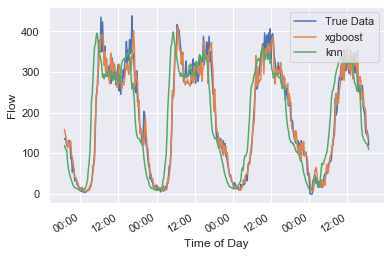

In [154]:
import matplotlib as mpl
d = '2006-10-25 19:00'
x = pd.date_range(d, periods=384, freq='15min')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y_test1[:384], label='True Data')

ax.plot(x, pred[:384], label="xgboost")
ax.plot(x, predicted[:384], label="knn")

plt.legend()
plt.grid(True)
plt.xlabel('Time of Day')
plt.ylabel('Flow')

date_format = mpl.dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.show()